In [10]:
import glob
import os
from PIL import Image,ImageOps
import random
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from os.path import join
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
TRAIN_PATH = '/content/drive/My Drive/Semantic dataset100/'
LOGS_Path = '/content/drive/My Drive/StegLogs/'
CHECKPOINTS_PATH = '/content/drive/My Drive/StegOutput/'


BATCH_SIZE = 8
LEARNING_RATE = .0001
BETA = .75

EXP_NAME = f"beta_{BETA}"

In [0]:
# Input files


files_list = glob.glob(join(TRAIN_PATH,"**/*"))
def normalize_batch(imgs):
    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])
                                                        
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

def get_img_batch(files_list,batch_size=32,size=(224,224),should_normalise=True):
   
    batch_cover = []
    batch_secret = []
   
    
    for i in range(batch_size):
        img_secret_path = random.choice(files_list)
        img_cover_path = random.choice(files_list)
        
        img_secret = Image.open(img_secret_path).convert("RGB")
        img_cover = Image.open(img_cover_path).convert("RGB")

        img_secret = np.array(ImageOps.fit(img_secret,size),dtype=np.float32)
        img_cover = np.array(ImageOps.fit(img_cover,size),dtype=np.float32)
        
        img_secret /= 255.
        img_cover /= 255.
        
        batch_cover.append(img_cover)
        batch_secret.append(img_secret)
        
    batch_cover,batch_secret = np.array(batch_cover) , np.array(batch_secret)
    
    if should_normalise:
        batch_cover = normalize_batch(batch_cover)
        batch_secret = normalize_batch(batch_secret)

    return batch_cover,batch_secret

In [0]:
# Prep Network
def get_prep_network_op(secret_tensor):
    
    with tf.variable_scope('prep_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)           
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3,conv_4x4,conv_5x5],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_5x5,conv_4x4,conv_3x3],axis=3,name='concat_final')

        return concat_final
    

# Hide Network
def get_hiding_network_op(cover_tensor,prep_output):
    
    with tf.variable_scope('hide_net'):
        concat_input = tf.concat([cover_tensor,prep_output],axis=3,name='images_features_concat')
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)          
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3,conv_4x4,conv_5x5],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_5x5,conv_4x4,conv_3x3],axis=3,name='concat_final')
        output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')
        
        return output
    
        
# Reveal Network       
def get_reveal_network_op(container_tensor):
    
    with tf.variable_scope('reveal_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3,conv_4x4,conv_5x5],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_5x5,conv_4x4,conv_3x3],axis=3,name='concat_final')
    
    output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')

    return output

def get_noise_layer_op(tensor,std=.1):
    with tf.variable_scope("noise_layer"):
        return tensor + tf.random_normal(shape=tf.shape(tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    
def get_loss_op(secret_true,secret_pred,cover_true,cover_pred,beta=.5):
    
    with tf.variable_scope("losses"):
        beta = tf.constant(beta,name="beta")
        secret_mse = tf.losses.mean_squared_error(secret_true,secret_pred)
        cover_mse = tf.losses.mean_squared_error(cover_true,cover_pred)
        final_loss = cover_mse + beta*secret_mse
        return final_loss , secret_mse , cover_mse 

def get_tensor_to_img_op(tensor):
    with tf.variable_scope("",reuse=True):
        t = tensor*tf.convert_to_tensor([0.229, 0.224, 0.225]) + tf.convert_to_tensor([0.485, 0.456, 0.406])
        return tf.clip_by_value(t,0,1)

In [0]:
def prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor):
    
    prep_output_op = get_prep_network_op(secret_tensor)
    hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
    noise_add_op = get_noise_layer_op(hiding_output_op)
    reveal_output_op = get_reveal_network_op(noise_add_op)
    
    loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op,beta=BETA)

    minimize_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_op,global_step=global_step_tensor)
    
    tf.summary.scalar('loss', loss_op,family='train')
    tf.summary.scalar('reveal_net_loss', secret_loss_op,family='train')
    tf.summary.scalar('cover_net_loss', cover_loss_op,family='train')

    tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='train')
    tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='train')
    tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='train')
    tf.summary.image('hidden_noisy',get_tensor_to_img_op(noise_add_op),max_outputs=1,family='train')
    tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='train')

    merged_summary_op = tf.summary.merge_all()
    
    return minimize_op, merged_summary_op 
    

In [0]:
# with tf.Session() as sess:
  # saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539.meta/')
  # saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539')
def prepare_test_graph(secret_tensor,cover_tensor):
    with tf.variable_scope("",reuse=True):
    
        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
        reveal_output_op = get_reveal_network_op(hiding_output_op)
        
        loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op)

        tf.summary.scalar('loss', loss_op,family='test')
        tf.summary.scalar('reveal_net_loss', secret_loss_op,family='test')
        tf.summary.scalar('cover_net_loss', cover_loss_op,family='test')

        tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='test')
        tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='test')
        tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='test')
        tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='test')

        merged_summary_op = tf.summary.merge_all()
  
        return merged_summary_op 

In [0]:
# with tf.Session() as sess:
  # saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539.meta/')
  # saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539')
def prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor):
    with tf.variable_scope("",reuse=True):

        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)

        reveal_output_op = get_reveal_network_op(covered_tensor)

        return hiding_output_op ,  reveal_output_op

In [17]:
sess = tf.InteractiveSession(graph=tf.Graph())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [18]:
# with tf.Session() as sess:
  # saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539.meta/')
  # saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539')

secret_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_prep")
cover_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_hide")
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')

train_op , summary_op = prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor)

writer = tf.summary.FileWriter(join(LOGS_Path,EXP_NAME),sess.graph)

test_op = prepare_test_graph(secret_tensor,cover_tensor)

covered_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="deploy_covered")
deploy_hide_image_op , deploy_reveal_image_op = prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use tf.cast instead.


In [19]:
saver = tf.train.Saver(max_to_keep=1)
sess.run(tf.global_variables_initializer())
saver.save(sess,'beta_0.75.chkp', global_step = 36072)
# saver.restore(sess,join(CHECKPOINTS_PATH,EXP_NAME))
# with tf.Session() as sess:
  # saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539.meta/')
  # saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539')



'beta_0.75.chkp-36072'

In [0]:
total_steps = len(files_list)//BATCH_SIZE + 1

In [0]:
 with tf.Session() as sess:
  new_saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-30865.meta/') #removed meta value here
  new_saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/StegOutput'))
  for ep in range(100):
      for step in range(total_steps):
          covers,secrets = get_img_batch(files_list=files_list,batch_size=BATCH_SIZE)
          sess.run([train_op],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
        
          if step % 10 ==0 :
            
              summary,global_step = sess.run([summary_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
              writer.add_summary(summary,global_step)
            
          if step % 100 ==0 :
            
              covers,secrets = get_img_batch(files_list=files_list,batch_size=1)
              summary,global_step = sess.run([test_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
              writer.add_summary(summary,global_step)

    
      save_path = saver.save(sess, join(CHECKPOINTS_PATH,EXP_NAME+".chkp"),global_step=global_step)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/StegOutput/beta_0.75.chkp-30865
Instructions for updating:
Use standard file APIs to delete files with this prefix.


In [0]:
# sess.close()

writer.close()
# with tf.Session() as sess:
  # saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539.meta/')
  # saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-5539')


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/StegOutput/beta_0.75.chkp-36072
(1, 224, 224, 3)


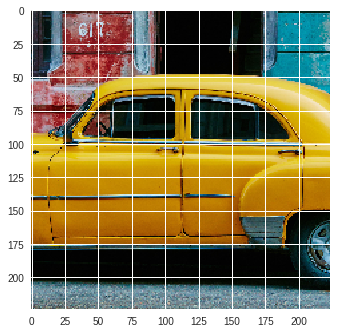

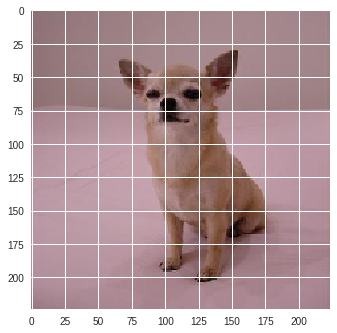

In [25]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-36072.meta/')
  saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-36072')

  covers,secrets = get_img_batch(files_list=files_list,batch_size=1)
  print(secrets.shape)

  cover = covers.squeeze()
  secret = secrets.squeeze()
  plt.imshow(denormalize_batch(cover))
  plt.show()
  plt.imshow(denormalize_batch(secret))
  plt.show()
  plt.imsave('/content/drive/My Drive/StegInput/cover.png', denormalize_batch(cover))
  plt.imsave('/content/drive/My Drive/StegInput/secret.png', denormalize_batch(secret))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/StegOutput/beta_0.75.chkp-30865


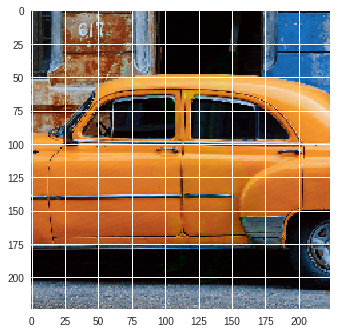

In [26]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-30865.meta/')
  saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-30865')
  hidden = sess.run(deploy_hide_image_op,feed_dict={'input_prep:0':secrets,'input_hide:0':covers})
  
  plt.imshow(denormalize_batch(hidden.squeeze()))
  # revealed = sess.run(deploy_reveal_image_op,feed_dict={'deploy_covered:0':hidden})

  # plt.imshow(denormalize_batch(revealed.squeeze()))
  plt.imsave('/content/drive/My Drive/StegSave/output.png', denormalize_batch(hidden.squeeze()))
  

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/StegOutput/beta_0.75.chkp-30865


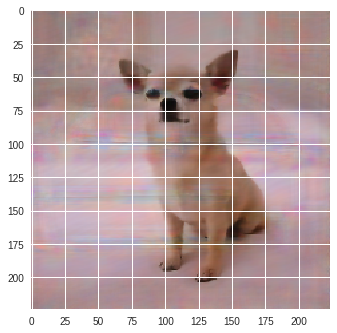

In [27]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('/content/drive/My Drive/StegOutput/beta_0.75.chkp-30865.meta/')
  saver.restore(sess, '/content/drive/My Drive/StegOutput/beta_0.75.chkp-30865')
  revealed = sess.run(deploy_reveal_image_op,feed_dict={'deploy_covered:0':hidden})

  plt.imshow(denormalize_batch(revealed.squeeze()))
  plt.imsave('/content/drive/My Drive/StegSave/output1.png', denormalize_batch(revealed.squeeze()))

In [30]:
plt.imshow(np.clip(hiding_output.squeeze(),0,1))

NameError: ignored

In [29]:
hiding_network_output = sess.run([hiding_output_op],
                                  feed_dict={secret_tensor:secrets,cover_tensor:covers})[0]

NameError: ignored